# II. Programming and critical analysis

In [306]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from termcolor import colored
import random

Consider the `heart-disease.csv` dataset available at the course webpage’s homework tab.
Using `sklearn`, apply a 5-fold stratified cross-validation with shuffling (`random_state=0`) for the assessment of predictive models along this section.

In [307]:
data = pd.read_csv('heart-disease.csv')
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [379]:
#%%writefile generate_splits.py

def generate_splits(df, N_SPLITS = 5):
    strat_kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split = strat_kfold.split(np.zeros(len(df)), df['target'])
    return split


Writing generate_splits.py


## 1\) Compare the performance of a $k$ NN with $k = 5$ and a naïve Bayes with Gaussian assumption (consider all remaining parameters as default).

### a) Plot two boxplots with the fold accuracies for each classifier. Is there one more stable than the other regarding performance? Why do you think that is the case? Explain.

In [419]:
#%%writefile run_knn_vs_nbayes.py
# Run models and store accuracies

N_NEIGHBORS = 5
knn = KNeighborsClassifier(n_neighbors=5)
nbayes = GaussianNB()

def fit_and_score(model, train, test):
    model = model.fit(train.drop('target', axis=1, inplace=False), train['target'])
    return model.score(test.drop('target', axis=1, inplace=False), test['target'])


def knn_vs_nbayes(df, scale=False):
    knn_accuracies = []
    nbayes_accuracies = []
    for train_index, test_index in generate_splits(df):
        train = df.loc[train_index]
        test = df.loc[test_index]
        if scale: 
            MINMAXSCALER = MinMaxScaler()
            MINMAXSCALER.fit_transform(train[['age','trestbps','chol','thalach','oldpeak']])

            #target = train['target'].copy().reset_index(drop=True)
            train[['age','trestbps','chol','thalach','oldpeak']] = MINMAXSCALER.transform(train[['age','trestbps','chol','thalach','oldpeak']].copy())
            #train['target'] = target

            #target = test['target'].copy().reset_index(drop=True)
            test[['age','trestbps','chol','thalach','oldpeak']] = MINMAXSCALER.transform(test[['age','trestbps','chol','thalach','oldpeak']].copy())
            #test['target'] = target
            train.head()

        knn_accuracies.append(fit_and_score(knn, train, test))
        nbayes_accuracies.append(fit_and_score(nbayes, train, test))
    return knn_accuracies, nbayes_accuracies

knn_accuracies, nbayes_accuracies = knn_vs_nbayes(data)


KNN Accuracies: [0.6229508196721312, 0.5737704918032787, 0.6721311475409836, 0.7, 0.7] | average = 0.6537704918032787
Naive Bayes Accuracies: [0.8852459016393442, 0.8032786885245902, 0.8032786885245902, 0.85, 0.8333333333333334] | average = 0.8350273224043716


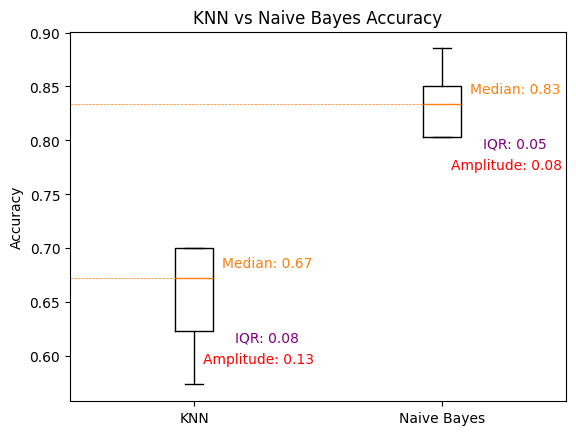

In [415]:
# Create visualization

def visualize_accuracies(knn_accuracies, nbayes_accuracies, xoffset, yoffset):
    print(colored(f'KNN Accuracies: {knn_accuracies} | average = {np.mean(knn_accuracies)}', 'green'))
    print(colored(f'Naive Bayes Accuracies: {nbayes_accuracies} | average = {np.mean(nbayes_accuracies)}', 'green'))
    fig = plt.boxplot([knn_accuracies, nbayes_accuracies], tick_labels=['KNN', 'Naive Bayes'])

    for i, line in enumerate(fig['medians']):
        x, y = line.get_xydata()[0]
        plt.text(x+xoffset, y+yoffset, f'Median: {y:.2f}', horizontalalignment='center', color='tab:orange')
        plt.axhline(y, color='tab:orange', linestyle='--', linewidth=0.5, xmax=0.5*x-0.2)
        q0 = fig['whiskers'][2*i].get_ydata()[1]
        q1 = fig['boxes'][i].get_ydata()[0]
        q3 = fig['boxes'][i].get_ydata()[2]
        q4 = fig['whiskers'][2*i+1].get_ydata()[1]
        iqr = q3 - q1
        amplitude = q4 - q0
        plt.text(x+xoffset, q1-yoffset, f'IQR: {iqr:.2f}', horizontalalignment='center', color='purple')
        plt.text(x+0.9*xoffset, q1-3*yoffset, f'Amplitude: {amplitude:.2f}', horizontalalignment='center', color='red')
        

    plt.title('KNN vs Naive Bayes Accuracy')
    plt.ylabel('Accuracy')
    return fig

fig = visualize_accuracies(knn_accuracies, nbayes_accuracies, 0.37, 0.01)
plt.savefig('report_figs/knn_vs_nbayes.png')
plt.show()

The smaller IQR and amplitude for Naïve Bayes’ accuracies suggest a more consistent performance across folds compared to $k$-NN. The smaller variation indicated by the low IQR is synonymous with bigger consistency.

This is likely the case because, while the Naïve Bayes Classifier learns global parameters from the whole train set, and then applies them to the test set, a $k$ NN classifier classifies each sample based on a local view of the train set.

The $k$ NN will largely be affected by local noise, while the Naïves Bayes global approach should minimize fluctuations.
Although the K Fold cross validation is stratified and randomised, the train set is different at every fold - which will cause major fluctuations locally.

In [ ]:
import seaborn as sns
from matplotlib.animation import FuncAnimation

splits = generate_splits(data)

for idx, (train_index, _) in enumerate(splits):
    train = data.loc[train_index]
    sns.pairplot(train, hue='target')
    plt.title(f'Split {idx + 1}')
    plt.savefig(f'pairplot_{idx}.png')

!ffmpeg -r 1 -i pairplot_%d.png -vcodec mpeg4 -y movie.mp4

### b) Report the accuracy of both models, this time scaling the data with a Min-Max scaler before training the models. Explain the impact that this preprocessing step has on the performance of each model, providing an explanation for the results.

KNN Accuracies: [0.8688524590163934, 0.819672131147541, 0.8524590163934426, 0.8, 0.8166666666666667] | average = 0.8315300546448088
Naive Bayes Accuracies: [0.8852459016393442, 0.8032786885245902, 0.8032786885245902, 0.85, 0.8333333333333334] | average = 0.8350273224043716


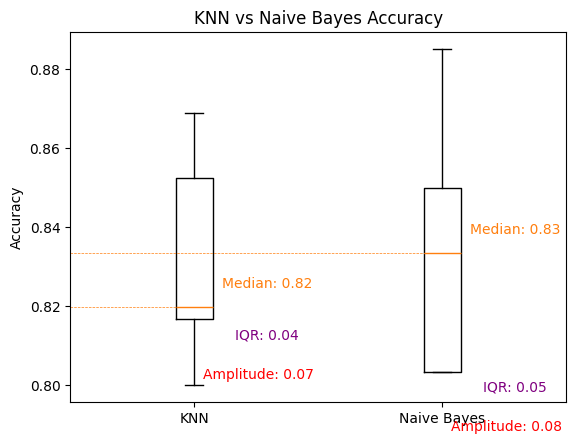

In [420]:
knn_accuracies_scaled, nbayes_accuracies_scaled = knn_vs_nbayes(data, scale=True)
fig = visualize_accuracies(knn_accuracies_scaled, nbayes_accuracies_scaled, 0.37, 0.005)
plt.savefig('report_figs/knn_vs_nbayes_scaled.png')
plt.show()

MinMax Scaling had a large impact on the performance of the $k$ NN model, but very little effect on the performance of the Naïve Bayes model.

MinMax Scaling rescales each feature to the [0,1] range, where its value corresponds to the relative position the value holds between the minimum and maximum values of each given variable. Since different variables have different ranges, MinMax Scaling affects each variable differently. By doing this, the distances within the dataset will change anisotropically.
Since the `heart-disease.csv` dataset has many different units, MinMax Scaling is crucial for ensuring that variations in all features contribute equally to the model’s decision-making process.

Since the $k$ NN model relies on distance calculation (such as Euclidean distance), MinMax Scaling heavily affects its output. 
On the other hand, the Naïve Bayes under a Gaussian assumption models the data's probability with normal distributions fitted to it. By taking in the mean and stdev as parameters and outputting a probability, this type of model already prioritises the variation of the data, and effectively normalises the data internally. This is because probabilities are confined to the [0,1] range, which is also the reason why MinMax Scaling does not affect it.


### c) Using `scipy`, test the hypothesis “the $k$ NN model is statistically superior to naïve Bayes regarding accuracy”, asserting whether it is true.

If we model the distribution of either model's accuracy as a Normal distribution, the hypothesis should be accepted if the probability of it being false (= $H_0$ being true) is below a threshold.
Let's say that threshold is the usual value of 5% and so let's test for p<0.05.

If we let:

$$X \sim \text{R.V. which represents the accuracy of the } kNN \text{ classifier} \\
Y \sim \text{R.V. which represents the accuracy of the } NB \text{ classifier}$$

Then `knn_accuracies_scaled` is a sample of $X$ and `nbayes_accuracies_scaled` is a sample of $Y$.

We define our hypotheses below:

$$H_0: \overline{X} - \overline{Y} \le 0 \text{  } (\iff \overline{\text{accuracy}}_{kNN} \le \overline{\text{accuracy}}_{NB})\\

H_1: \overline{X} - \overline{Y} \gt 0 \text{  } (\iff \overline{\text{accuracy}}_{kNN} \gt \overline{\text{accuracy}}_{NB})$$

In [416]:
# %%writefile test_knn_vs_nbayes.py
# SCALED DATA ######################################
print(colored('H0: KNN Classifier is not better than Naive Bayes Classifier when using MinMax Scaling', 'blue'))
test_result = stats.ttest_rel(knn_accuracies_scaled, nbayes_accuracies_scaled, alternative='greater')     # [alternative=] ‘greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.

print('T-statistic: ', test_result.statistic)
print('P-value: ', test_result.pvalue)
print('Degrees of Freedom: ', test_result.df)

if test_result.pvalue < 0.05:
    print(colored('We can reject the null hypothesis, and conclude that the KNN Classifier is better than the Naive Bayes Classifier, when using MinMax Scaling', "green"))
else:
    print(colored('We cannot reject the null hypothesis, thus we cannot conclude that the KNN model is better than the Naive Bayes model, when using MinMax Scaling', "red"))

H0: KNN Classifier is not better than Naive Bayes Classifier when using MinMax Scaling
T-statistic:  -0.20765598807967692
P-value:  0.577179266103123
Degrees of Freedom:  4
We cannot reject the null hypothesis, thus we cannot conclude that the KNN model is better than the Naive Bayes model, when using MinMax Scaling


In [417]:
# UNSCALED DATA ####################################################
print(colored('H0: KNN Classifier is not better than Naive Bayes Classifier without using MinMax Scaling', 'blue'))
test_result_no_scaling = stats.ttest_rel(knn_accuracies, nbayes_accuracies, alternative='greater')

print('T-statistic: ', test_result_no_scaling.statistic)
print('P-value: ', test_result_no_scaling.pvalue)
print('Degrees of Freedom: ', test_result_no_scaling.df)

if test_result_no_scaling.pvalue < 0.05:
    print(colored('We can reject the null hypothesis, and conclude that the KNN Classifier is better than the Naive Bayes Classifier, without using MinMax Scaling', "green"))
else:
    print(colored('We cannot reject the null hypothesis, thus we cannot conclude that the KNN model is better than the Naive Bayes model, without using MinMax Scaling', "red"))

H0: KNN Classifier is not better than Naive Bayes Classifier without using MinMax Scaling
T-statistic:  -6.690315237001677
P-value:  0.9987020187220139
Degrees of Freedom:  4
We cannot reject the null hypothesis, thus we cannot conclude that the KNN model is better than the Naive Bayes model, without using MinMax Scaling


## 2) Using a 80-20 train-test split, vary the number of neighbors of a \(kNN\) classifier using \(k = \{1, 5, 10, 20, 30\}\). Additionally, for each \(k\), train one classifier using uniform weights and distance weights.

In [398]:
%%writefile train_test_split.py
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1, inplace=False), data['target'], test_size=0.20, random_state=0, stratify=data['target'])
ks = [1,5,10,20,30]

Writing train_test_split.py


### a) Plot the train and test accuracy for each model.

In [399]:
%%writefile knn_models_compare.py
models_accuracies = []

for k in ks:
    for weight in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
        knn.fit(X_train, y_train)
        train_acc = knn.score(X_train, y_train)
        test_acc = knn.score(X_test, y_test)
        models_accuracies.append({'k': k, 'weight': weight, 'train_acc': train_acc, 'test_acc': test_acc})

models_accuracies = pd.DataFrame(models_accuracies)
models_accuracies


Writing knn_models_compare.py


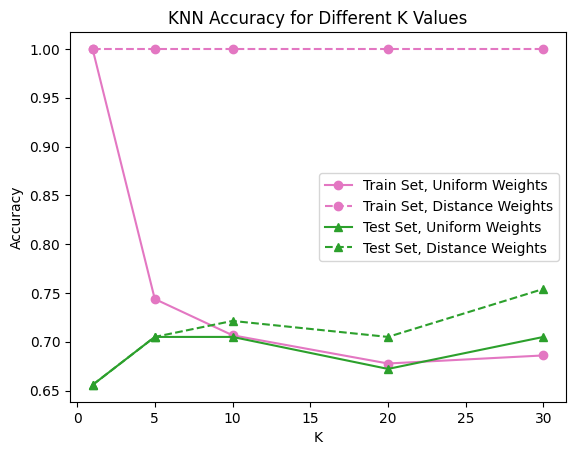

In [418]:
fig, ax = plt.subplots()
# Uniform Weights
uniform = models_accuracies[models_accuracies['weight'] == 'uniform']
ax.title.set_text('Uniform Weights')
ax.plot(uniform['k'], uniform['train_acc'], label='Train Set, Uniform Weights', marker='o', color='tab:pink')


# Distance Weights
distance = models_accuracies[models_accuracies['weight'] == 'distance']
ax.title.set_text('Distance Weights')
ax.plot(distance['k'], distance['train_acc'], label='Train Set, Distance Weights', marker='o', linestyle='--', color='tab:pink')
ax.plot(uniform['k'], uniform['test_acc'], label='Test Set, Uniform Weights', marker='^', color='tab:green')
ax.plot(distance['k'], distance['test_acc'], label='Test Set, Distance Weights', marker='^', linestyle='--', color='tab:green')

ax.legend()
ax.set_xlabel('K')
ax.set_ylabel('Accuracy')

ax.set_title('KNN Accuracy for Different K Values')
plt.savefig('report_figs/knn_k_accuracy.png')

#### Miscellaneous Plots

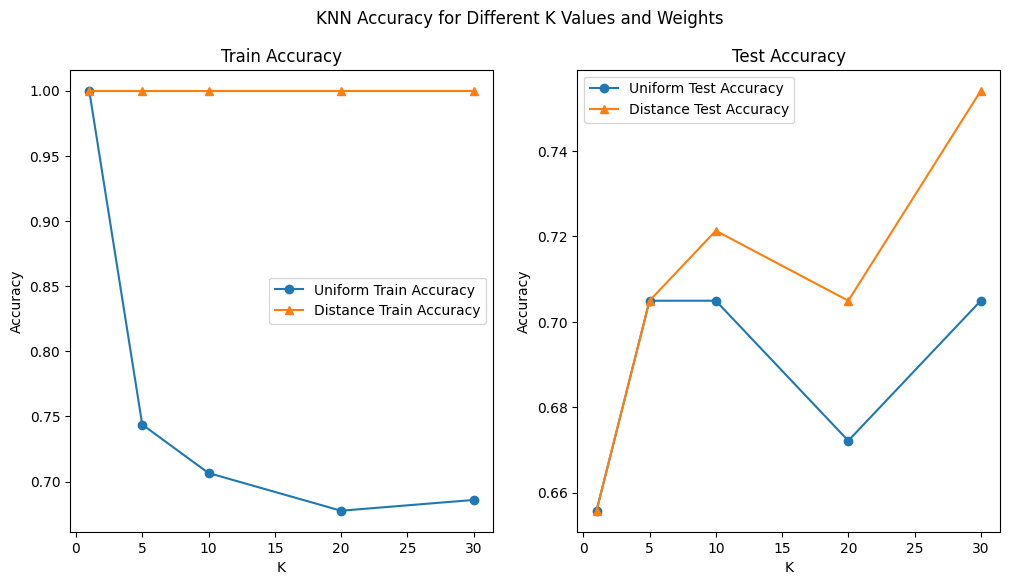

In [401]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Train Accuracy
ax[0].plot(models_accuracies[models_accuracies['weight'] == 'uniform']['k'], 
           models_accuracies[models_accuracies['weight'] == 'uniform']['train_acc'], 
           label='Uniform Train Accuracy', marker='o')
ax[0].plot(models_accuracies[models_accuracies['weight'] == 'distance']['k'], 
           models_accuracies[models_accuracies['weight'] == 'distance']['train_acc'], 
           label='Distance Train Accuracy', marker='^')

# Test Accuracy
ax[1].plot(models_accuracies[models_accuracies['weight'] == 'uniform']['k'], 
           models_accuracies[models_accuracies['weight'] == 'uniform']['test_acc'], 
           label='Uniform Test Accuracy', marker='o')
ax[1].plot(models_accuracies[models_accuracies['weight'] == 'distance']['k'], 
           models_accuracies[models_accuracies['weight'] == 'distance']['test_acc'], 
           label='Distance Test Accuracy', marker='^')

# Set titles and labels
ax[0].title.set_text('Train Accuracy')
ax[1].title.set_text('Test Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('K')
    ax[i].set_ylabel('Accuracy')

fig.suptitle('KNN Accuracy for Different K Values and Weights')
plt.show()

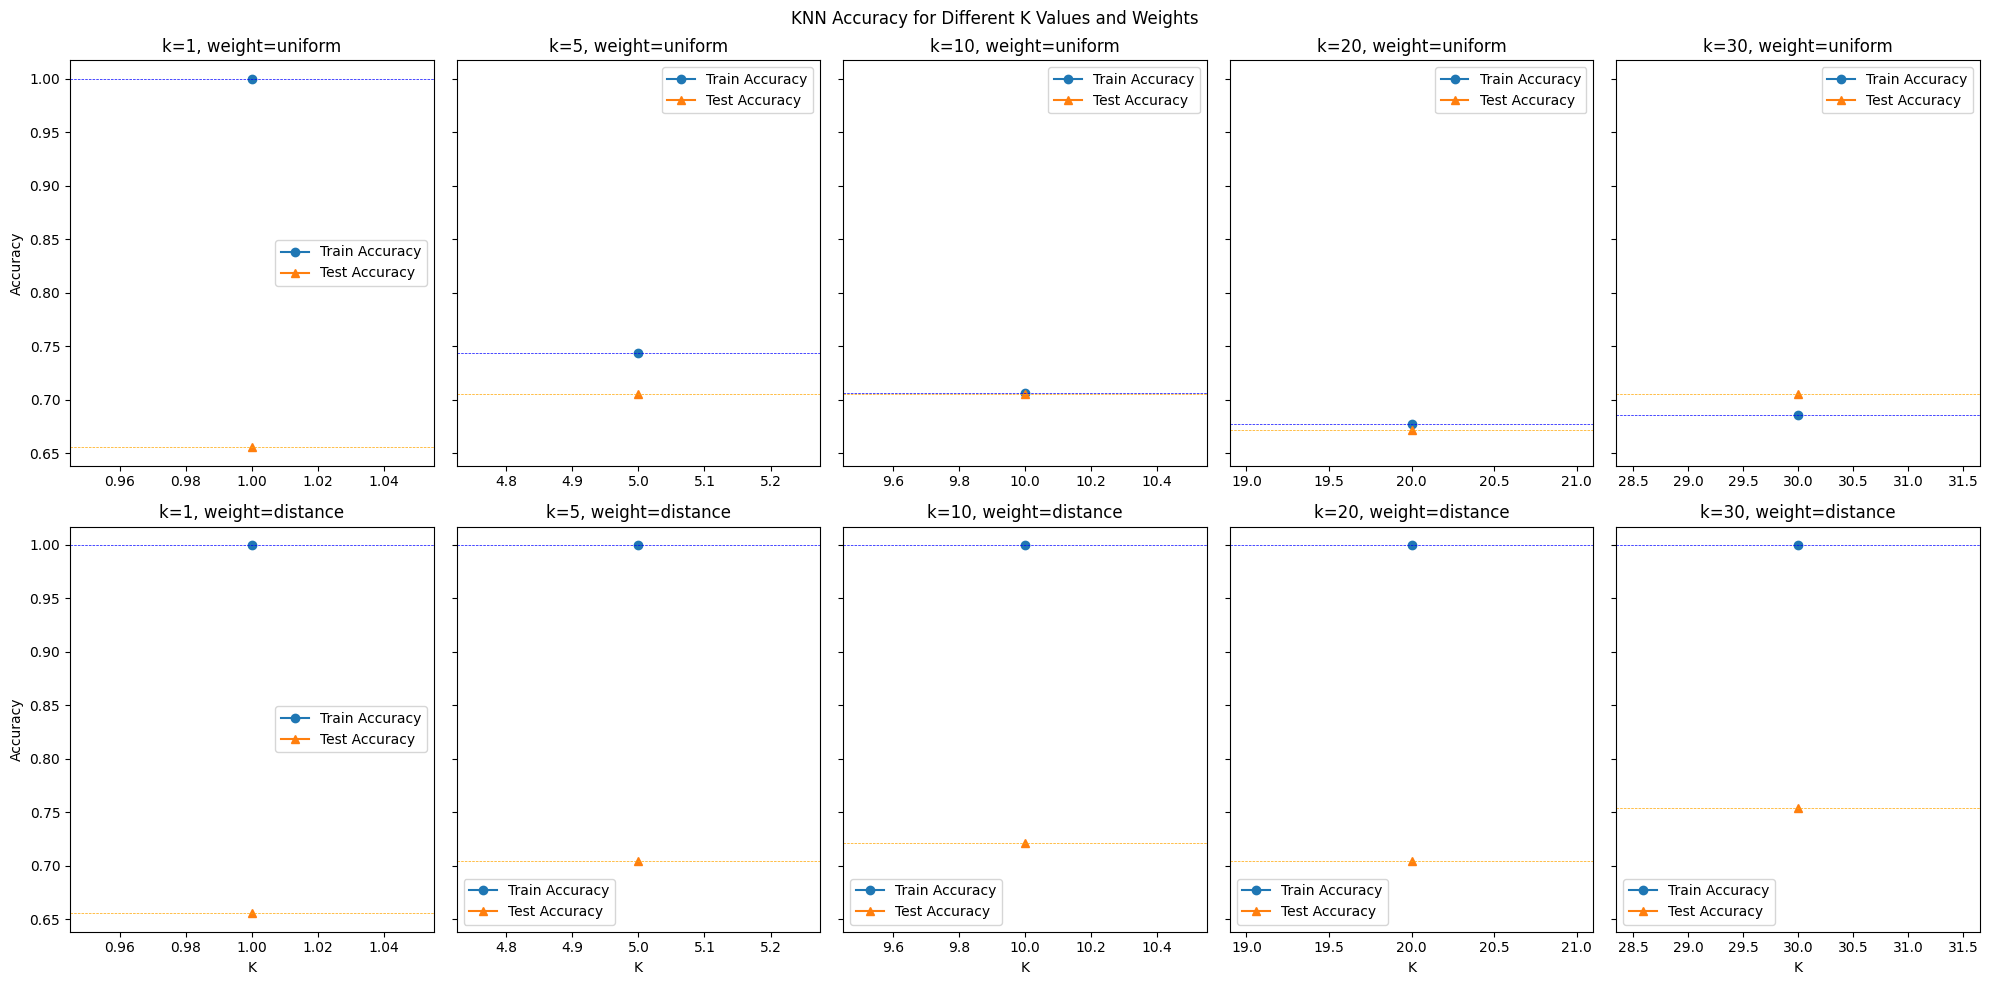

In [402]:
fig, axes = plt.subplots(nrows=2, ncols=len(ks), figsize=(20, 10), sharey=True)

for i, k in enumerate(ks):
    for j, weight in enumerate(['uniform', 'distance']):
        subset = models_accuracies[(models_accuracies['k'] == k) & (models_accuracies['weight'] == weight)]
        ax = axes[j, i]
        ax.plot(subset['k'], subset['train_acc'], label='Train Accuracy', marker='o')
        ax.plot(subset['k'], subset['test_acc'], label='Test Accuracy', marker='^')
        ax.axhline(y=subset['train_acc'].values[0], color='blue', linestyle='--', linewidth=0.5)
        ax.axhline(y=subset['test_acc'].values[0], color='orange', linestyle='--', linewidth=0.5)
        ax.set_title(f'k={k}, weight={weight}')
        
        if i == 0:
            ax.set_ylabel('Accuracy')
        if j == 1:
            ax.set_xlabel('K')
        ax.legend()

fig.suptitle('KNN Accuracy for Different K Values and Weights')
plt.tight_layout()


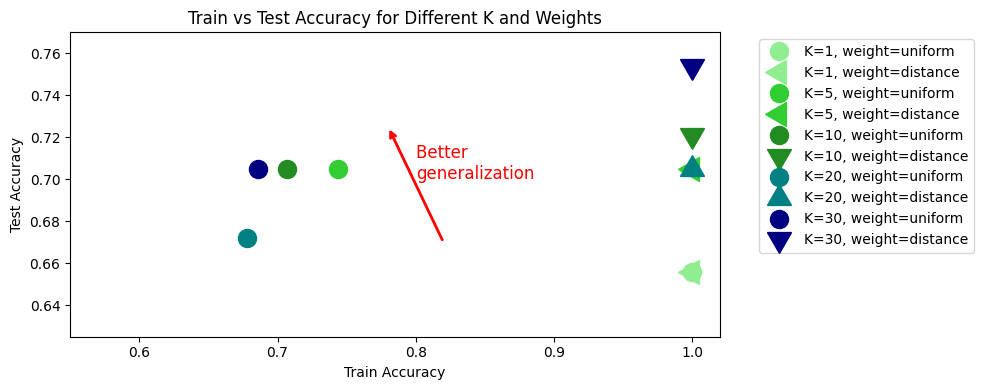

In [403]:

plt.subplots(figsize=(10, 4))

# Define colors for different k values
colors_green = {1: 'lightgreen', 5: 'limegreen', 10: 'forestgreen', 20: 'teal', 30: 'navy'}

for k in ks:
    for weight in ['uniform', 'distance']:
        subset = models_accuracies[(models_accuracies['k'] == k) & (models_accuracies['weight'] == weight)]
        color = colors_green[k]
        marker = (3, 0, k*90) if weight == 'distance' else 'o'
        size = 13 if weight == 'uniform' else 20
        plt.plot(subset['train_acc'], subset['test_acc'], marker=marker, linestyle='', label=f'K={k}, weight={weight}', color=color, markersize=size)

plt.xlabel('Train Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Train vs Test Accuracy for Different K and Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0.625, 0.77)
plt.xlim(0.55, 1.02)

plt.annotate('', xy=(0.78, 0.725), xytext=(0.82, 0.67),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=2))
plt.text(0.8, 0.7, 'Better \ngeneralization', fontsize=12, color='red')
plt.tight_layout()

plt.savefig('report_figs/train_vs_test_space.png')

### b) Explain the impact of increasing the neighbors on the generalization ability of the models.

For the models with uniform weights, the train accuracy starts out very high and then decays down to a plateau around the 67% mark. The test accuracy, on the other hand, starts out at around 60% and goes up to around 70%, at which point it also seems to plateau.

We can interpret that, as $k$ increases, then the model starts generalizing better - since, although the train accuracy decreases, the test accuracy increases, meaning the model performs better on unseen data -, although there seems to be a point where there is no longer an improvement (around $k=20$). We can then interpret that there should be a "sweet spot" for the value of $k$.

On the other hand, on models with distance weights, performance on the train dataset is stable at 100% regardless of the $k$ value. Performace on the test set seems to increase with $k$, although one can likely also expect to see a plateau with a higher $k$, given the small variability of the rightmost points' test accuracy.


By increasing the number of neighbors, we're effectively increasing the voting pool, which should reduce random noise fluctuations. With a greater voting pool, then, the true features of the data become more evident. As $k$ becomes too big, however, we underfit, since we lose the main advantage of the algorithm: leveraging the neighborhood of a given point. By having too big a neighborhood, then it will encompass data points which aren't as closely related to the one we are classifying.


## 3) Considering the unique properties of the `heart-disease.csv` dataset, identify two possible difficulties of the naïve Bayes model used in the previous exercises when learning from the given dataset.

The `heart-disease.csv` dataset's [information page](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) could be found on Kaggle via a quick search.

We can first consider the way that `GaussianNB()` models data. (1) By fitting Gaussians to all variables, it disregards the possibility that their distributions may be different.
Categorical Variables are not well modelled by Normal Distributions here, and are assumed to be continuous variables. Besides, even the continuous variables may not have an underlying Gaussian distribution: if we refer to the dataset's Data Card, we can see a chart like the one below, where the variable `oldpeak`, doesn't quite resemble the normal distribution, in green. We also plotted other distributions for comparison.

Besides, (2) the Naïve Bayes model assumes all variables are independent. But this is not always the case. Rather, the real meaning of the dataset would intuitively tell us that such is definitely not the case. An example: `chol` (for cholestrol) and `age` are most likely not independent.

If we take $\chi^2$ independence tests, we can further confirm this intuition - the p-value for the test done between these 2 variables is so close to 1 that we should almost be certain they are dependent.

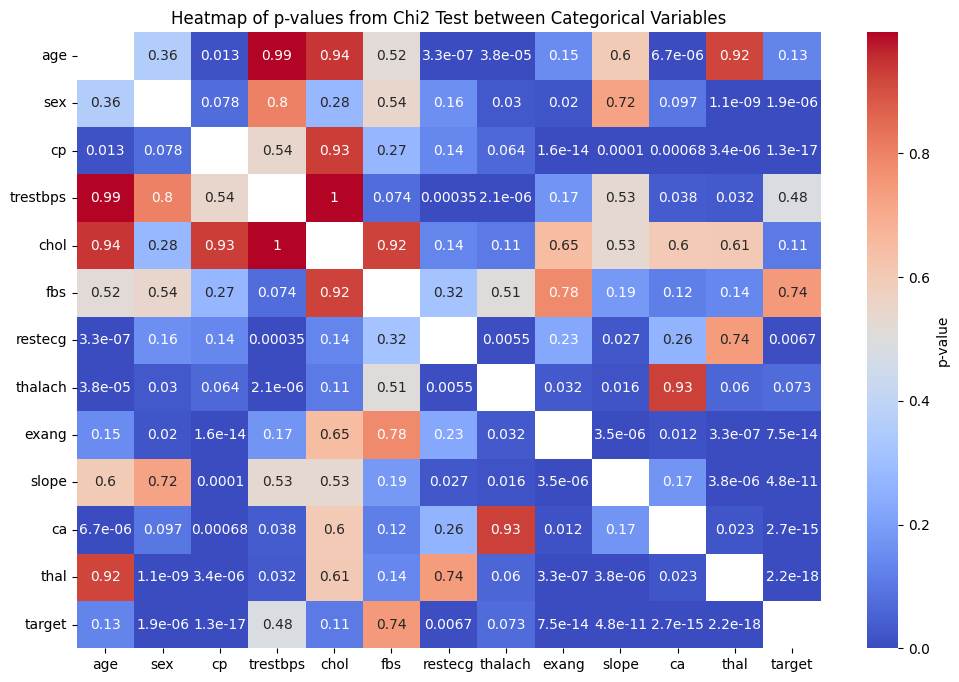

In [321]:
from scipy.stats import chi2_contingency
import seaborn as sns


def chi2_test_pairs(df):
    chi2_results = {}
    categorical_columns = df.select_dtypes(include=['int64', 'object']).columns
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 != col2:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p, dof, ex = chi2_contingency(contingency_table)
                chi2_results[(col1, col2)] = {'chi2': chi2, 'p-value': p, 'dof': dof}
    return chi2_results


chi2_results_pairs = chi2_test_pairs(data)


p_values = pd.DataFrame(index=data.select_dtypes(include=['int64', 'object']).columns, 
                        columns=data.select_dtypes(include=['int64', 'object']).columns)

for (col1, col2), result in chi2_results_pairs.items():
    p_values.loc[col1, col2] = result['p-value']


p_values = p_values.astype(float)


plt.figure(figsize=(12, 8))
sns.heatmap(p_values, annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'})
plt.title('Heatmap of p-values from Chi2 Test between Categorical Variables')
plt.savefig('report_figs/chi2_heatmap.png')
plt.show()

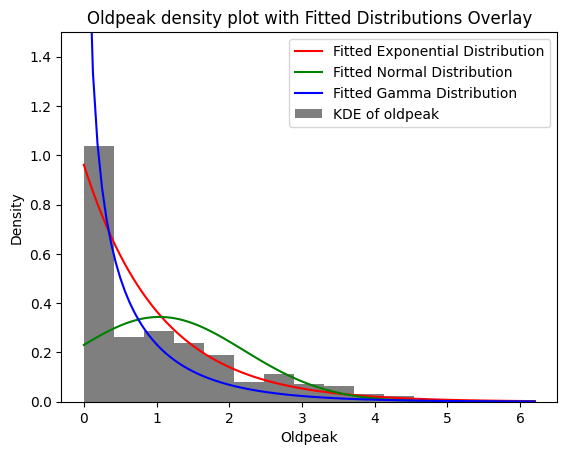

In [322]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon
from scipy.stats import gamma

oldpeak = data['oldpeak']


params_expon = expon.fit(oldpeak)
params_norm = norm.fit(oldpeak)


x = np.linspace(oldpeak.min(), oldpeak.max(), 100)


pdf_expon = expon.pdf(x, *params_expon)
pdf_norm = norm.pdf(x, *params_norm)
plt.plot(x, pdf_expon, 'r-', label='Fitted Exponential Distribution')


plt.plot(x, pdf_norm, 'g-', label='Fitted Normal Distribution')

params_gamma = gamma.fit(oldpeak)


pdf_gamma = gamma.pdf(x, *params_gamma)


plt.plot(x, pdf_gamma, 'b-', label='Fitted Gamma Distribution')


plt.hist(oldpeak, color='black', label='KDE of oldpeak', density=True, bins=15, alpha=0.5)


plt.ylim(0, 1.5)
plt.xlabel('Oldpeak')
plt.ylabel('Density')
plt.title('Oldpeak density plot with Fitted Distributions Overlay')
plt.legend()

plt.savefig('report_figs/oldpeak_density.png')
# Show the plot
plt.show()